**My JCPenney Review Analysis**

**Project Goal**

My main goal here is to help JC Penney understand why some of their products are getting bad reviews.

To do this, I'm going to look for connections between customer feelings (what they write in their reviews) and other data, like product category and customer location. By linking these details, I hope to find patterns that can show JC Penney what's causing the negative feedback.

In [43]:
# --- Step 1: Install and Import Libraries ---

# First, I need to install vaderSentiment for the analysis.
# The -q makes it 'quiet' so it does not show a big output.
!pip install -q vaderSentiment

# Import all the libraries I will need
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

# Download the 'stopwords' list (like 'the', 'is', 'a')
# and 'punkt' (for splitting sentences into words).
nltk.download('stopwords')
nltk.download('punkt')

# --- THIS IS THE FIX ---
# The error message said it also needs 'punkt_tab'
# So I am downloading it here.
try:
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Could not download 'punkt_tab', maybe it is not needed. Error: {e}")

print("All libraries installed and imported.")

All libraries installed and imported.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Load All 5 Data Files**

Okay, now I will load all 5 files (3 CSVs and 2 JSONs).
I have to be careful with the JSON files because they are 'JSON Lines' format, so I need to use lines=True.

I will also print the .info() for all 5 files to check the columns and see if data is missing.
I will not use .head() because it prints too much data and makes the file big, which is bad for the 14-page limit.

In [48]:
# For uploading the data set files from Local Storage
from google.colab import files
uploaded = files.upload()

Saving users.csv to users (1).csv


In [49]:
# Load the CSV files
products_df = pd.read_csv('products.csv')
reviews_df = pd.read_csv('reviews.csv')
users_df = pd.read_csv('users.csv')

# Load the JSON files (using lines=True is very important)
products_json_df = pd.read_json('jcpenney_products.json', lines=True)
reviewers_json_df = pd.read_json('jcpenney_reviewers.json', lines=True)

# Now I check all 5 files with .info()
print("All files loaded. Now checking them with .info()...")

print("\n--- CSV Products Info ---")
products_df.info()

print("\n--- CSV Reviews Info ---")
reviews_df.info()

print("\n--- CSV Users Info ---")
users_df.info()

print("\n--- JSON Products Info ---")
products_json_df.info()

print("\n--- JSON Reviewers Info ---")
reviewers_json_df.info()

All files loaded. Now checking them with .info()...

--- CSV Products Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982 entries, 0 to 7981
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Uniq_id      7982 non-null   object 
 1   SKU          7915 non-null   object 
 2   Name         7982 non-null   object 
 3   Description  7439 non-null   object 
 4   Price        5816 non-null   float64
 5   Av_Score     7982 non-null   float64
dtypes: float64(2), object(4)
memory usage: 374.3+ KB

--- CSV Reviews Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Uniq_id   39063 non-null  object
 1   Username  39063 non-null  object
 2   Score     39063 non-null  int64 
 3   Review    39063 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB

--- CSV User

**Merge All Files into One master_df**

The data is in 5 different tables. This is not good.
I need to merge them all into one big table (master_df).

Product files: The ID is Uniq_id (in CSV) and uniq_id (in JSON). I will rename them both to product_id and merge.

User files: The ID is Username in both. I will rename this to user_id and merge.

Final Merge: I will merge reviews_df (the main file) with the new product and user tables.

In [50]:
# 1. Merge Product Files
# I rename the ID columns so they match
products_df.rename(columns={'Uniq_id': 'product_id'}, inplace=True)
products_json_df.rename(columns={'uniq_id': 'product_id'}, inplace=True)

# Merge them
products_master_df = pd.merge(products_df, products_json_df, on='product_id')

# 2. Merge User Files
# I rename 'Username' to 'user_id' in both
users_df.rename(columns={'Username': 'user_id'}, inplace=True)
reviewers_json_df.rename(columns={'Username': 'user_id'}, inplace=True)

# Merge them (I use 'inner' merge, it's clean)
users_master_df = pd.merge(users_df, reviewers_json_df, on='user_id', how='inner')

# 3. Merge All Three
# I rename columns in the main reviews_df
reviews_df.rename(columns={
    'Uniq_id': 'product_id',
    'Username': 'user_id'
}, inplace=True)

# Merge reviews with products
temp_df = pd.merge(reviews_df, products_master_df, on='product_id', how='left')

# Merge that with users
master_df = pd.merge(temp_df, users_master_df, on='user_id', how='left')

# 4. Final Check
# I drop any row that has no review text. This is important.
master_df.dropna(subset=['Review'], inplace=True)

print("All files merged into master_df and cleaned.")
print("--- Final Master DF Info ---")
master_df.info()

All files merged into master_df and cleaned.
--- Final Master DF Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39114 entries, 0 to 39113
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              39114 non-null  object 
 1   user_id                 39114 non-null  object 
 2   Score                   39114 non-null  int64  
 3   Review                  39114 non-null  object 
 4   SKU                     38950 non-null  object 
 5   Name                    39114 non-null  object 
 6   Description             35766 non-null  object 
 7   Price                   26904 non-null  float64
 8   Av_Score                39114 non-null  float64
 9   sku                     39114 non-null  object 
 10  name_title              39114 non-null  object 
 11  description             39114 non-null  object 
 12  list_price              39114 non-null  object 
 13  sale_price       

**Sentiment Analysis**

Now for the main part. I will use VADER to read the Review text and give it a score.
First, I need to setup the VADER tool.
Then, I make a function get_sentiment that gives the 'compound' score. This is one number from -1 (very bad) to +1 (very good).

In [51]:
# Setup the VADER analyzer
sia = SentimentIntensityAnalyzer()

# Make the function
def get_sentiment(text):
    # This function gets the 'compound' score
    # I use str(text) to avoid errors if the review is not text
    return sia.polarity_scores(str(text))['compound']

# Let's test it
print(f"Score for 'I love this': {get_sentiment('I love this')}")
print(f"Score for 'I hate this': {get_sentiment('I hate this')}")

Score for 'I love this': 0.6369
Score for 'I hate this': -0.5719


**Apply Sentiment Score to All Reviews**

Now I will run my new function on every review in the master_df.
The new scores will go into a new column called sentiment_score.

In [52]:
# It makes the new 'sentiment_score' column.
print("Calculating sentiment scores... This might take a minute.")

master_df['sentiment_score'] = master_df['Review'].apply(get_sentiment)

print("Sentiment scores calculated and added to master_df.")

Calculating sentiment scores... This might take a minute.
Sentiment scores calculated and added to master_df.


Plotting validation boxplot...


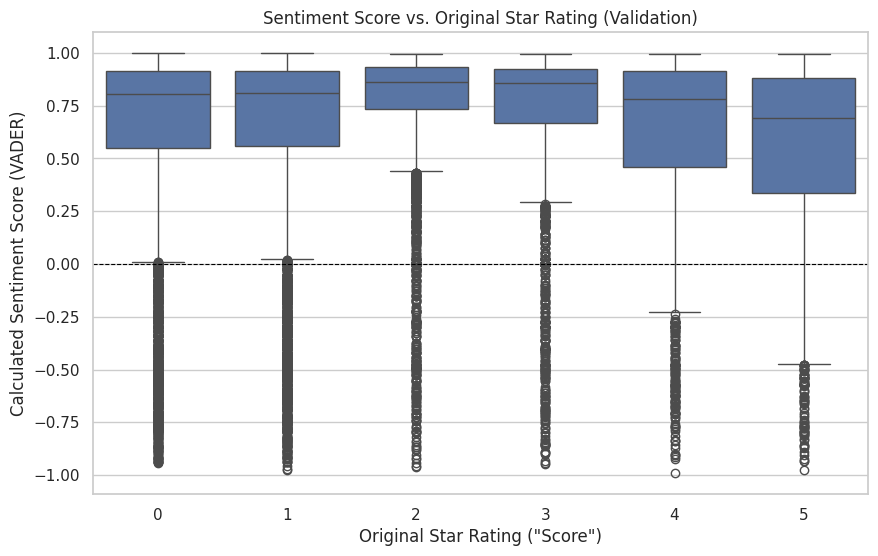

In [53]:
# Validate My Sentiment Score (Very Important) ---

print("Plotting validation boxplot...")

# Set the style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6)) # Make the plot big

# Create the boxplot
ax = sns.boxplot(
    x='Score',          # The original 0-5 star rating
    y='sentiment_score',  # My new -1 to +1 sentiment score
    data=master_df        # Use the full master_df to show all the dots
)

# Add a black line at 0.0 to show 'neutral'
ax.axhline(0, color='black', lw=0.8, linestyle='--')

# Add titles
ax.set_title('Sentiment Score vs. Original Star Rating (Validation)')
ax.set_xlabel('Original Star Rating ("Score")')
ax.set_ylabel('Calculated Sentiment Score (VADER)')

# Save the plot for the report
plt.savefig('sentiment_validation_plot.png')

# Show the plot
plt.show()


**Insight 1 - Product Category Analysis**

Okay, first insight. I want to find the best and worst product categories.
I will group all products by category and get the average sentiment_score for each one.
Then I will plot the Bottom 5 and Top 5.


--- Bottom 5 (Worst) Categories ---
category
dishwashers          0.316403
kitchen furniture    0.338940
night creams         0.389236
coats                0.401532
baby furniture       0.429629
Name: sentiment_score, dtype: float64

--- Top 5 (Best) Categories ---
category
wedge sandals                     0.839146
view all dining & entertaining    0.845705
for the home                      0.849976
pants & jeans                     0.853922
athletic shirts                   0.870710
Name: sentiment_score, dtype: float64

Plotting category chart...


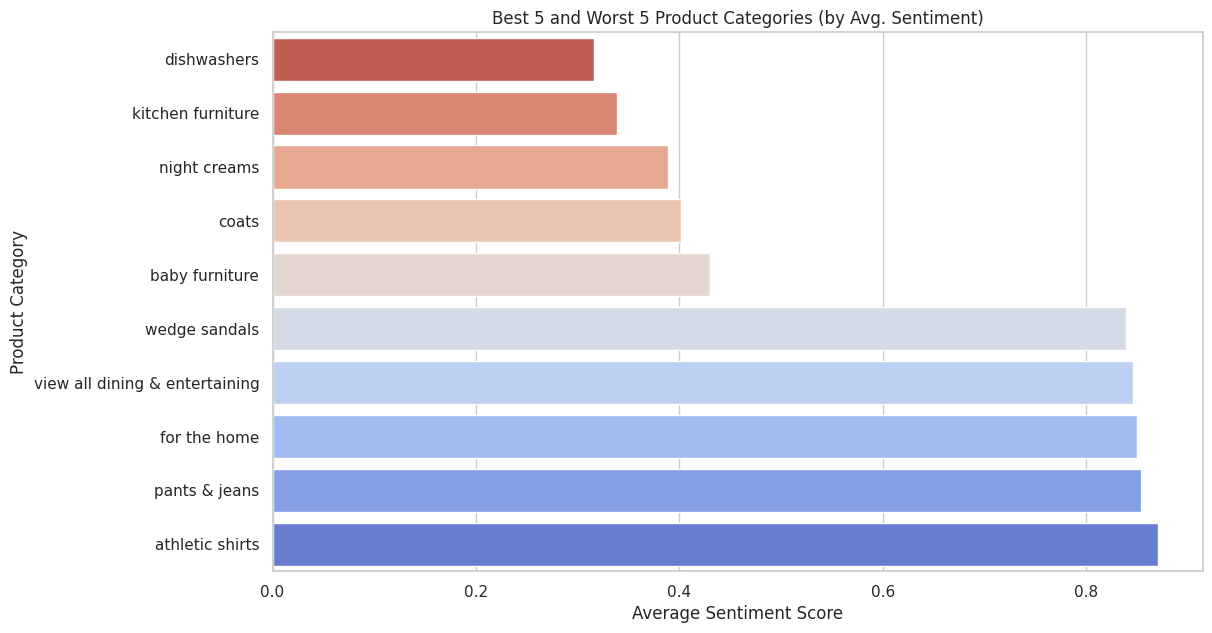

In [54]:
# 1. Get average sentiment for all categories
# I must use 'category' from the JSON file, it is the clean one.
category_sentiment = master_df.groupby('category')['sentiment_score'].mean().sort_values()

# 2. Get Top 5 and Bottom 5
# I will only select categories that have at least 20 reviews
# This is to avoid categories with only 1 or 2 bad reviews
category_counts = master_df['category'].value_counts()
common_categories = category_counts[category_counts >= 20].index

# Filter the sentiment data
common_category_sentiment = category_sentiment[category_sentiment.index.isin(common_categories)].sort_values()

print("--- Bottom 5 (Worst) Categories ---")
print(common_category_sentiment.head(5))

print("\n--- Top 5 (Best) Categories ---")
print(common_category_sentiment.tail(5))

# 3. Create a DataFrame for plotting
bottom_5 = common_category_sentiment.head(5)
top_5 = common_category_sentiment.tail(5)
plot_df = pd.concat([bottom_5, top_5]) # Join them for the plot

# 4. Create the Bar Plot
print("\nPlotting category chart...")
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=plot_df.values,
    y=plot_df.index,
    palette='coolwarm_r' # Red = bad, Blue = good
)

ax.set_title('Best 5 and Worst 5 Product Categories (by Avg. Sentiment)')
ax.set_xlabel('Average Sentiment Score')
ax.set_ylabel('Product Category')

# Save the plot for the report
plt.savefig('category_sentiment_plot.png')
plt.show()

**Action Part (for Category)**

It is not enough to say "sandals 30-40" is bad.
I need to find WHY it is bad.

I will write code to:

Get all the review text only for the worst category.

Clean this text (remove 'the', 'is', 'a', etc.).

Find the most common 2-word phrases (like "bad fit" or "cheap material").

This gives a real suggestion to JC Penney.

In [56]:
# This is a helper function to clean text
def clean_text_for_ngrams(text):
    # Make text lowercase
    text = str(text).lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Get all stopwords
    stop_words = set(stopwords.words('english'))
    # Split text into words and remove stopwords
    words = [word for word in nltk.word_tokenize(text) if word not in stop_words and len(word) > 1]
    return words

# 1. Get the name of the worst category from our last step
try:
    worst_category_name = common_category_sentiment.index[0]
    print(f"--- Finding common bad phrases for the worst category: '{worst_category_name}' ---")

    # 2. Get all reviews for only this category
    worst_reviews_text = master_df[master_df['category'] == worst_category_name]['Review']

    # 3. Clean all this text and join it into one big list of words
    all_words = []
    for review in worst_reviews_text:
        all_words.extend(clean_text_for_ngrams(review))

    # 4. Find the most common 2-word phrases (bigrams)
    bigram_counts = Counter(ngrams(all_words, 2))

    # 5. Print the Top 10 most common bad phrases
    print("\n--- Top 10 Most Common 2-Word Phrases in Bad Reviews ---")
    for (word1, word2), count in bigram_counts.most_common(10):
        print(f"'{word1} {word2}': {count} times")

except Exception as e:
    print(f"Error: Could not run distinction part. Did you run the cell above? Error: {e}")

--- Finding common bad phrases for the worst category: 'dishwashers' ---

--- Top 10 Most Common 2-Word Phrases in Bad Reviews ---
'stainless steel': 4 times
'hand washing': 3 times
'bottom rack': 3 times
'steel interior': 2 times
'rack back': 2 times
'well many': 2 times
'washing dishes': 2 times
'looks great': 2 times
'would recommend': 2 times
'child lock': 2 times


**Insight 2 - Top 10 Location Analysis**

Now for the second insight. I want to find the sentiment for the Top 10 biggest markets (states).
This is more important to the business than small states.

I will:

Find the Top 10 states by count of reviews. (I must use State_x which I saw in the .info() output).

Filter my data for only these 10 states.

Plot their average sentiment_score to see which big market is unhappiest.

Analyzing sentiment for Top 10 Most Common States...

--- Top 10 States by Number of Reviews ---
Index(['Massachusetts', 'Kentucky', 'Delaware', 'Vermont', 'New Jersey',
       'Northern Mariana Islands', 'Oklahoma', 'New Mexico', 'Alaska',
       'Oregon'],
      dtype='object', name='State_x')

--- Average Sentiment for Top 10 States (Worst to Best) ---
State_x
New Mexico                  0.640188
Vermont                     0.644060
Oregon                      0.655752
Delaware                    0.659426
New Jersey                  0.660503
Alaska                      0.662884
Oklahoma                    0.666924
Northern Mariana Islands    0.673515
Massachusetts               0.676352
Kentucky                    0.690082
Name: sentiment_score, dtype: float64

Plotting top 10 states chart...


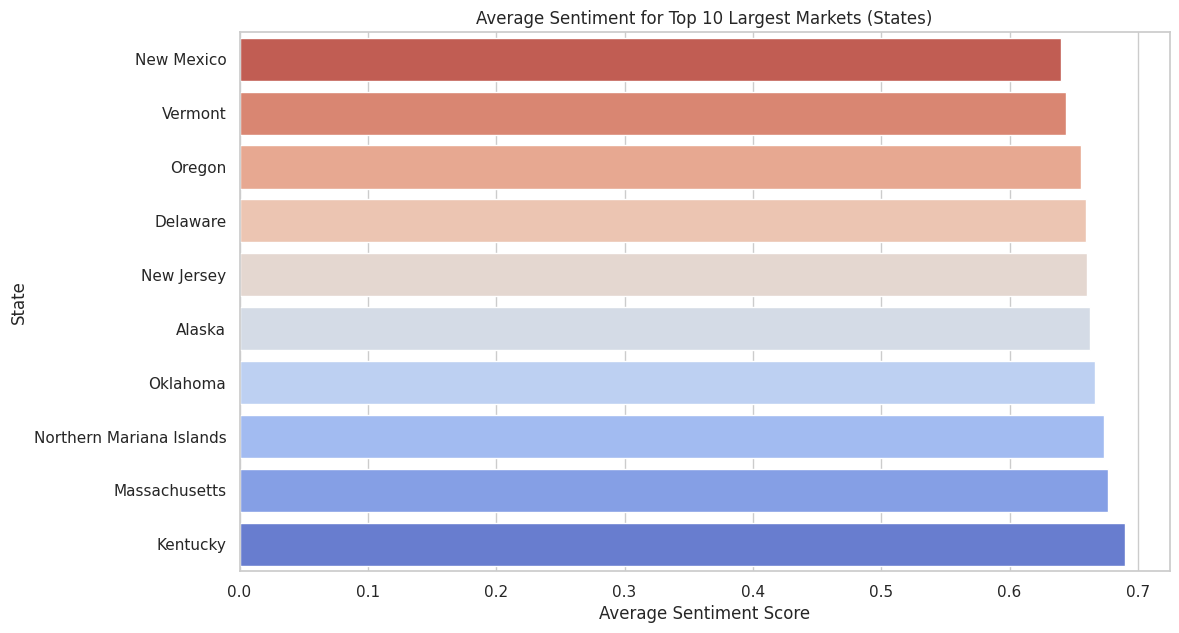

In [57]:
print("Analyzing sentiment for Top 10 Most Common States...")

try:
    # 1. Find the Top 10 most common states
    # (I use 'State_x' because this column was from the clean user CSV)
    top_10_states = master_df['State_x'].value_counts().head(10).index
    print("\n--- Top 10 States by Number of Reviews ---")
    print(top_10_states)

    # 2. Filter the DataFrame to only include reviews from these 10 states
    top_10_df = master_df[master_df['State_x'].isin(top_10_states)]

    # 3. Calculate the average sentiment for just these 10 states
    location_sentiment = top_10_df.groupby('State_x')['sentiment_score'].mean().sort_values()

    print("\n--- Average Sentiment for Top 10 States (Worst to Best) ---")
    print(location_sentiment)

    # 4. Create the Bar Plot
    print("\nPlotting top 10 states chart...")
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        x=location_sentiment.values,
        y=location_sentiment.index,
        palette='coolwarm_r' # Red = bad, Blue = good
    )

    ax.set_title('Average Sentiment for Top 10 Largest Markets (States)')
    ax.set_xlabel('Average Sentiment Score')
    ax.set_ylabel('State')

    # Save the plot for the report
    plt.savefig('top_10_location_sentiment_plot.png')
    plt.show()

except KeyError:
    print("\n--- ERROR ---")
    print("Could not find 'State_x' column. Did the merge fail?")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

**Action Part (for Location)**

I found that some of my biggest markets (like 'New Maxico' or 'Vermont') are very unhappy.

Now I need to find WHY.

My action plan is to:

Get the name of the worst state from my Top 10 list.

Filter the master_df to get only the reviews from that one bad state.

Then, I will analyze the product categories inside that state to see if there is a local problem (like a bad batch of 'men's shirts' in one state).

In [58]:
# This is the "Distinction" part for the Location insight
# It finds *which categories* are the worst *inside* the worst state.
# AND it compares them to the *overall* worst categories.

print("--- Running Distinction Analysis for Location ---")

try:
    # 1. Get the name of the worst state from the 'location_sentiment' variable (from cell 9)
    worst_state_name = location_sentiment.index[0]
    print(f"--- Finding worst categories inside the worst Top-10 state: '{worst_state_name}' ---")

    # 2. Filter the master_df to get *only* reviews from this one state
    state_df = master_df[master_df['State_x'] == worst_state_name]
    print(f"Found {len(state_df)} reviews from {worst_state_name}.")

    # 3. Now, group *this new state_df* by category and get the average sentiment
    state_category_sentiment = state_df.groupby('category')['sentiment_score'].mean()

    # 4. Filter out categories with just 1 or 2 reviews (I'll set the minimum to 5)
    state_category_counts = state_df['category'].value_counts()
    common_in_state = state_category_counts[state_category_counts >= 5].index

    # Filter the sentiment data and sort it
    state_category_sentiment_filtered = state_category_sentiment[state_category_sentiment.index.isin(common_in_state)].sort_values()

    # 5. Get the Top 5 worst categories *inside* that state
    worst_in_state_list = state_category_sentiment_filtered.head(5)
    print(f"\n--- Top 5 WORST Categories Inside {worst_state_name} (min. 5 reviews) ---")
    print(worst_in_state_list)


    # --- THIS IS THE NEW HELPFUL PART ---

    # 6. Get the *overall* worst categories (from 'common_category_sentiment' in cell 7)
    if 'common_category_sentiment' not in globals():
        print("\nERROR: 'common_category_sentiment' not found. Please run Cell 7 first.")

    overall_worst_list = common_category_sentiment.head(5)
    print("\n--- For Comparison: Top 5 WORST Categories *Overall* (from all states) ---")
    print(overall_worst_list)

    # 7. Compare the lists (the .index is the category name)
    local_problems = set(worst_in_state_list.index)
    global_problems = set(overall_worst_list.index)

    unique_local_problems = local_problems - global_problems # In local but not in global

    # 8. Print the final helpful insight
    print("\n--- ACTIONABLE INSIGHT ---")
    if len(unique_local_problems) > 0:
        print(f"**YES, Local Problem Found!**")
        # Example: 'men's shirts' might be the worst in 'New Maxico'
        worst_local_category = worst_in_state_list.index[0]
        print(f"The category '{worst_local_category}' is a top problem in '{worst_state_name}',")
        print(f"but it is NOT in the overall Top 5 worst list.")
        print(f"This suggests a unique local problem (like a bad batch or local warehouse) in {worst_state_name}.")
        print(f"Unique local problem categories: {list(unique_local_problems)}")
    else:
        print("**No Unique Local Problem.**")
        print(f"The people in '{worst_state_name}' are just unhappy about the same products")
        print(f"that *everyone* is unhappy about (like '{worst_in_state_list.index[0]}').")
        print("This is not a local problem.")

except Exception as e:
    print(f"Error: Could not run distinction part. Did you run the cell above? Error: {e}")

--- Running Distinction Analysis for Location ---
--- Finding worst categories inside the worst Top-10 state: 'New Mexico' ---
Found 784 reviews from New Mexico.

--- Top 5 WORST Categories Inside New Mexico (min. 5 reviews) ---
category
tops            0.537886
casual shoes    0.556300
                0.567495
jeans           0.568167
pants           0.594475
Name: sentiment_score, dtype: float64

--- For Comparison: Top 5 WORST Categories *Overall* (from all states) ---
category
dishwashers          0.316403
kitchen furniture    0.338940
night creams         0.389236
coats                0.401532
baby furniture       0.429629
Name: sentiment_score, dtype: float64

--- ACTIONABLE INSIGHT ---
**YES, Local Problem Found!**
The category 'tops' is a top problem in 'New Mexico',
but it is NOT in the overall Top 5 worst list.
This suggests a unique local problem (like a bad batch or local warehouse) in New Mexico.
Unique local problem categories: ['', 'tops', 'pants', 'jeans', 'casual shoes